# Image Captioning using GRU on Flickr8K dataset

In [1]:
import os
import time
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import sys, time, os, warnings
import numpy as np
import pandas as pd
from collections import Counter 
from tensorflow.keras.preprocessing.image import load_img
from nltk.tokenize import word_tokenize
warnings.filterwarnings("ignore")

## Loading and Preprocessing the Dataset

In [2]:
file = open('Flickr8k_text/Flickr8k.token.txt','r') # Opening File
text = file.read() # Reading File
file.close() # Closing File
datatxt = []
for line in text.split('\n'): # Loop runs for No. of Images present
    col = line.split('\t') # Splits into 2 tuples on basis of '\t'
    if len(col) == 1:
        continue
    w = col[0].split("#") # Splits 1st tuple on basis of '#'
    datatxt.append(w + [col[1].lower()])
df_txt_flickr = pd.DataFrame(datatxt,columns=["filename","index","caption"])
uni_filenames = np.unique(df_txt_flickr.filename.values)  # uni_filenames stores unique file name e.g. '1000268201_693b08cb0e.jpg'
print("Total no. of Unique File Names: {}".format(len(uni_filenames)))

Total no. of Unique File Names: 8092


In [3]:
import string
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(str.maketrans('','',string.punctuation))
    return(text_no_punctuation)

In [4]:
def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)

In [5]:
def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)

In [6]:
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)
for i, caption in enumerate(df_txt_flickr.caption.values): 
    # enumerate() Adds a counter to an iterable & returns it as enumerate object
    newcaption = text_clean(caption)
    if(i<10): # Printing the first 10 Captions for example
        print(newcaption)
    df_txt_flickr["caption"].iloc[i] = newcaption

 child in pink dress is climbing up set of stairs in an entry way
 girl going into wooden building
 little girl climbing into wooden playhouse
 little girl climbing the stairs to her playhouse
 little girl in pink dress going into wooden cabin
 black dog and spotted dog are fighting
 black dog and tricolored dog playing with each other on the road
 black dog and white dog with brown spots are staring at each other in the street
 two dogs of different breeds looking at each other on the road
 two dogs on pavement moving toward each other


In [7]:
from copy import copy
def add_start_end_seq_token(captions):
    caps = []
    for txt in captions:
        txt = 'startseq ' + txt + ' endseq'  # Adding <startseq> and <endseq> to all captions
        caps.append(txt)
    return(caps)
df_txt_flickr0 = copy(df_txt_flickr)
df_txt_flickr0["caption"] = add_start_end_seq_token(df_txt_flickr["caption"])
print(df_txt_flickr0.head(5))
del df_txt_flickr

                    filename index  \
0  1000268201_693b08cb0e.jpg     0   
1  1000268201_693b08cb0e.jpg     1   
2  1000268201_693b08cb0e.jpg     2   
3  1000268201_693b08cb0e.jpg     3   
4  1000268201_693b08cb0e.jpg     4   

                                             caption  
0  startseq  child in pink dress is climbing up s...  
1   startseq  girl going into wooden building endseq  
2  startseq  little girl climbing into wooden pla...  
3  startseq  little girl climbing the stairs to h...  
4  startseq  little girl in pink dress going into...  


## Modeling and Feature Extraction: ResNet-50

In [8]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Model

# Load the ResNet50 model without the top (final classification layer)
model_resnet = ResNet50(include_top=False, weights='imagenet')

# Modify the model to remove the last layer (i.e., choose a different output layer)
model_resnet_modified = Model(inputs=model_resnet.input, outputs=model_resnet.layers[-2].output)

# Print model summary
model_resnet_modified.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [9]:
jpgs = os.listdir('Flickr8k_Dataset/Flicker8k_Dataset')
print("Number of .jpg files in Flicker8k Dataset: {}".format(len(jpgs)))

Number of .jpg files in Flicker8k Dataset: 8091


In [10]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
from collections import OrderedDict

images = OrderedDict()  # To preserve the Order of Dictionary Keys
npix = 224  # No. of Pixels 
target_size = (npix,npix,3)  # Target Size of the Image

for i,name in enumerate(jpgs):
    filename = 'Flickr8k_Dataset/Flicker8k_Dataset' + '/' + name  # Load an image from file
    image = load_img(filename, target_size=target_size)
    image = img_to_array(image)  # Convert the image pixels to a Numpy Array
    nimage = preprocess_input(image)
    y_pred = model_resnet_modified.predict(nimage.reshape( (1,) + nimage.shape)) 
    images[name] = y_pred.flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━

In [11]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input

dimages, keepindex = [],[]
nd=(df_txt_flickr0["index"].values)
b = [(int(i)==0) for i in nd]
df_txt_flickr0 = df_txt_flickr0.loc[df_txt_flickr0["index"].values == "0",: ]

for i, fnm in enumerate(df_txt_flickr0.filename):
    if fnm in images.keys():
        dimages.append(images[fnm])
        keepindex.append(i)

fnames = df_txt_flickr0["filename"].iloc[keepindex].values
dcaptions = df_txt_flickr0["caption"].iloc[keepindex].values
dimages = np.array(dimages)


In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

# Maximum number of words in the dictionary
count_words = 22000

# Initialize tokenizer with a limit of 8000 words
tokenizer = Tokenizer(num_words=8000)

# Fit tokenizer on the provided captions
tokenizer.fit_on_texts(dcaptions)

# Vocabulary size (len of word_index + 1)
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size}")

# Convert captions to sequences
dtexts = tokenizer.texts_to_sequences(dcaptions)

# Print the first 5 sequences
print(dtexts[:5])

Vocabulary size: 4476
[[1, 38, 3, 66, 144, 7, 124, 52, 406, 9, 367, 3, 24, 2351, 522, 2], [1, 12, 8, 5, 752, 8, 17, 368, 2], [1, 48, 15, 170, 3, 584, 101, 3, 41, 9, 551, 1198, 11, 55, 213, 3, 1076, 2], [1, 10, 621, 6, 150, 27, 23, 8, 101, 46, 112, 2], [1, 10, 3, 24, 82, 96, 1199, 19, 162, 2]]


In [13]:
prop_test, prop_val = 0.2, 0.2 
N = len(dtexts)
Ntest, Nval = int(N*prop_test), int(N*prop_val)
def split_test_val_train(dtexts,Ntest,Nval):
    return(dtexts[:Ntest], dtexts[Ntest:Ntest+Nval],dtexts[Ntest+Nval:])
dt_test,  dt_val, dt_train   = split_test_val_train(dtexts,Ntest,Nval)
di_test,  di_val, di_train   = split_test_val_train(dimages,Ntest,Nval)
fnm_test,fnm_val, fnm_train  = split_test_val_train(fnames,Ntest,Nval)

In [14]:
maxlen = np.max([len(text) for text in dtexts])
print(maxlen)

30


In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def preprocessing(dtexts, dimages, maxlen, vocab_size):
    N = len(dtexts)
    print("# captions/images = {}".format(N))
    assert(N==len(dimages))
    Xtext, Ximage, ytext = [],[],[]
    for text, image in zip(dtexts, dimages):
        for i in range(1, len(text)):
            in_text, out_text = text[:i], text[i]
            if len(in_text) < maxlen:
                in_text = pad_sequences([in_text], maxlen=maxlen).flatten()
                out_text = to_categorical(out_text, num_classes=vocab_size)
                Xtext.append(in_text)
                Ximage.append(image)
                ytext.append(out_text)

    Xtext = np.array(Xtext)
    Ximage = np.array(Ximage)
    ytext = np.array(ytext)
    print(" {} {} {}".format(Xtext.shape,Ximage.shape,ytext.shape))
    return Xtext, Ximage, ytext

    
maxlen = 50  # maximum length of input sequences
vocab_size = 10000  # size of the vocabulary

Xtext_train, Ximage_train, ytext_train = preprocessing(dt_train, di_train, maxlen, vocab_size)
Xtext_val, Ximage_val, ytext_val = preprocessing(dt_val, di_val, maxlen, vocab_size)

# captions/images = 4855
 (49631, 50) (49631, 100352) (49631, 10000)
# captions/images = 1618
 (16353, 50) (16353, 100352) (16353, 10000)


## GRU Model

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Print vocabulary size (assuming it's already defined)
print(vocab_size)

# Embedding dimension
dim_embedding = 128

# Image input and feature extraction layer
input_image = layers.Input(shape=(di_train.shape[1],))
fimage = layers.Dense(256, activation='relu', name="ImageFeature")(input_image)

# Text input and sequence model (Embedding + GRU)
input_txt = layers.Input(shape=(maxlen,))
ftxt = layers.Embedding(vocab_size, dim_embedding)(input_txt)
ftxt = layers.GRU(256, name="CaptionFeature")(ftxt)  # GRU with 256 units

# Concatenate image features and text features
decoder = layers.concatenate([fimage, ftxt])

# Output layer for vocabulary classification
output = layers.Dense(vocab_size, activation='softmax')(decoder)

# Define the final model
model_res = models.Model(inputs=[input_image, input_txt], outputs=output)

# Compile the model with loss and optimizer
model_res.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Print model summary
print(model_res.summary())


10000


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 100352)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 50, 128)   │  1,280,000 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ImageFeature        │ (None, 256)       │ 25,690,368 │ input_layer_1[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CaptionFeature      │ (None, 256)       │    296,448 │ embedding[0][0]   │
│ (GRU)               │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 512)       │          0 │ ImageFeature[0][… │
│ (Concatenate)       │                   │            │ CaptionFeature[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10000)     │  5,130,000 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 32,396,816 (123.58 MB)

 Trainable params: 32,396,816 (123.58 MB)

 Non-trainable params: 0 (0.00 B)

None


In [31]:
start = time.time()
hist = model_res.fit([Ximage_train, Xtext_train], ytext_train, epochs=3, verbose=1, batch_size=32, validation_data=([Ximage_val, Xtext_val], ytext_val))
end = time.time()
print("Run Time {:3.2f}MIN".format((end - start )/60))
print(Ximage_train.shape,Xtext_train.shape,ytext_train.shape)

Epoch 1/3
1551/1551 [==============================] - 1687s 1s/step - loss: 5.0296 - accuracy: 0.2026 - val_loss: 4.4498 - val_accuracy: 0.2490
Epoch 2/3
1551/1551 [==============================] - 1597s 1s/step - loss: 4.0744 - accuracy: 0.2660 - val_loss: 4.2439 - val_accuracy: 0.2771
Epoch 3/3
1551/1551 [==============================] - 1601s 1s/step - loss: 3.6233 - accuracy: 0.2963 - val_loss: 4.2420 - val_accuracy: 0.2791
Run Time 81.41MIN
(49631, 100352) (49631, 50) (49631, 10000)


Plotting Loss & Validation Loss:


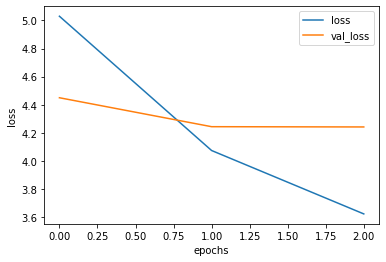

In [32]:
print('Plotting Loss & Validation Loss:')
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [33]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])

def predict_caption(image, start_text='startseq'):
    '''
    image.shape = (1, 4462)
    '''

    in_text = start_text
    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen)
        yhat = model_res.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]
        in_text += " " + newword
        if newword == "endseq":
            break
    return in_text


In [35]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])
nkeep = 5
pred_good, pred_bad, bleus = [], [], [] 
count = 0 
for jpgfnm, image_feature, tokenized_text in zip(fnm_test, di_test, dt_test):
    count += 1
    if count % 200 == 0:
        print("  {:4.2f}% is done..".format(100*count/float(len(fnm_test))))
    caption_true = [ index_word[i] for i in tokenized_text ]     
    caption_true = caption_true[1:-1] # Removing startreg & endreg
    
    # Captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    caption = caption.split()
    caption = caption[1:-1] # Removing startreg & endreg
    
    # Calculate BLEU scores
    smoothing = SmoothingFunction().method1  # Choose smoothing method
    bleu1 = sentence_bleu([caption_true], caption, weights=(1, 0, 0, 0), smoothing_function=smoothing)
    bleu2 = sentence_bleu([caption_true], caption, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing)
    bleu3 = sentence_bleu([caption_true], caption, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothing)
    bleu4 = sentence_bleu([caption_true], caption, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing)
    
    bleus.append((bleu1, bleu2, bleu3, bleu4))
    
    # Store good and bad predictions
    if bleu4 > 0.7 and len(pred_good) < nkeep:
        pred_good.append((bleu4, jpgfnm, caption_true, caption))
    elif bleu4 < 0.3 and len(pred_bad) < nkeep:
        pred_bad.append((bleu4, jpgfnm, caption_true, caption))

# Calculate mean BLEU scores for the test set
bleus = np.array(bleus)
mean_bleu1 = np.mean(bleus[:, 0])
mean_bleu2 = np.mean(bleus[:, 1])
mean_bleu3 = np.mean(bleus[:, 2])
mean_bleu4 = np.mean(bleus[:, 3])
print("The Mean BLEU-1 Score for the Test Set is {:4.3f}".format(mean_bleu1))
print("The Mean BLEU-2 Score for the Test Set is {:4.3f}".format(mean_bleu2))
print("The Mean BLEU-3 Score for the Test Set is {:4.3f}".format(mean_bleu3))
print("The Mean BLEU-4 Score for the Test Set is {:4.3f}".format(mean_bleu4))


  12.36% is done..
  24.72% is done..
  37.08% is done..
  49.44% is done..
  61.80% is done..
  74.17% is done..
  86.53% is done..
  98.89% is done..
The Mean BLEU-1 Score for the Test Set is 0.138
The Mean BLEU-2 Score for the Test Set is 0.050
The Mean BLEU-3 Score for the Test Set is 0.029
The Mean BLEU-4 Score for the Test Set is 0.022
